In [6]:
#---


# 🧠 Image Classification – Model Training (ResNet18)

#This notebook focuses on **training and fine-tuning** a convolutional neural network (CNN) using **transfer learning**.  
#We will build on our earlier exploration and prepare a high-performing image classification model for API deployment.

#---

### 🎯 Objectives
#- Load and preprocess CIFAR-10 dataset  
#- Fine-tune a pretrained **ResNet18** model using transfer learning  
#- Track training and validation performance  
#- Save the trained model for inference in the FastAPI app  

#---


In [2]:
# ✅ Imports and Configuration


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

In [3]:
# Check for GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
## 🧩 1. Data Preparation

# We’ll reuse the same normalization values from our exploration notebook for consistency.  
# Two `DataLoader` objects will be created: one for training and one for validation/testing.

In [4]:
# Define transforms (normalization values consistent with CIFAR-10)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root="../data", train=True,
                            download=True, transform=transform_train)
testset = datasets.CIFAR10(root="../data", train=True,
                           download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

classes = trainset.classes
print("Classes:", classes)

100%|█████████████████████████████████████████████████████████████████| 170498071/170498071 [00:03<00:00, 46417730.14it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
## 📘 Theory Notes — Why CNNs Work & Why Transfer Learning Helps

#---

### 🧠 Why Convolutional Neural Networks (CNNs) Work

#CNNs are specialized neural networks designed for **visual understanding**.  
#They learn spatial hierarchies — from **edges and colors** in early layers to **complex shapes and objects** in deeper layers.

#Key architectural ideas:
#- **Local connectivity:** filters (kernels) focus on small image regions at a time.  
#- **Shared weights:** the same filter slides across the image — reducing parameters.  
#- **Pooling layers:** downsample and retain key spatial features, increasing invariance to translation or scale.  
#- **Stacked convolutions:** build compositional features — edges → corners → textures → objects.

#In short, CNNs extract **spatially aware feature representations** that generalize well for image recognition tasks.

#---

### 🔁 Why Use Transfer Learning

#Training a CNN from scratch on limited data is inefficient and prone to overfitting.  
#**Transfer learning** leverages a pretrained model (e.g., ResNet18 trained on ImageNet) and adapts it to your smaller dataset.

#Benefits:
#- **Faster convergence:** pretrained weights already encode useful visual features.  
#- **Reduced data requirement:** the model starts from a strong prior instead of random weights.  
#- **Improved performance:** especially when your dataset resembles ImageNet (natural images).  

#Common approaches:
#1. **Feature extraction:** freeze most layers, train only the classifier head (as we’re doing).  
#2. **Fine-tuning:** unfreeze later layers gradually for deeper adaptation.

#---

#📈 *In this notebook, we apply transfer learning with ResNet18 to fine-tune its final layers for CIFAR-10 — demonstrating efficient reuse of pretrained knowledge.*


In [ ]:
## 🧠 2. Model Setup — Transfer Learning with ResNet18

# We'll use a **pretrained ResNet18** model from torchvision.  
# The final fully connected layer will be replaced to match the 10 CIFAR-10 classes.

In [5]:
# Load pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze early layers (optional)
for param in model.parameters():
    param.requires_grad = False

# Replace final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

model = model.to(device)
print(model.fc)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/kevinwoods/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 51.0MB/s]

Linear(in_features=512, out_features=10, bias=True)


In [6]:
## ⚙️ 3. Define Loss Function and Optimizer
# We'll use cross-entropy loss (standard for classification) and the Adam optimizer for efficient gradient updates.

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [8]:
## 🔁 4. Training Loop
# We’ll iterate through the dataset for multiple epochs, tracking both training and validation accuracy.

epochs = 10
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(testloader)
    val_losses.append(avg_val_loss)
    accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:48<00:00, 16.14it/s]


Epoch [1/10] - Train Loss: 1.7266, Val Loss: 1.7295, Accuracy: 39.82%


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:50<00:00, 15.59it/s]


Epoch [2/10] - Train Loss: 1.7121, Val Loss: 1.7264, Accuracy: 40.90%


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:51<00:00, 15.22it/s]


Epoch [3/10] - Train Loss: 1.7015, Val Loss: 1.7315, Accuracy: 40.22%


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:50<00:00, 15.37it/s]


Epoch [4/10] - Train Loss: 1.7051, Val Loss: 1.7428, Accuracy: 40.60%


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:50<00:00, 15.39it/s]


Epoch [5/10] - Train Loss: 1.6997, Val Loss: 1.7671, Accuracy: 39.21%


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:51<00:00, 15.25it/s]


Epoch [6/10] - Train Loss: 1.6990, Val Loss: 1.7147, Accuracy: 41.38%


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:51<00:00, 15.24it/s]


Epoch [7/10] - Train Loss: 1.7020, Val Loss: 1.7291, Accuracy: 40.61%


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:51<00:00, 15.04it/s]


Epoch [8/10] - Train Loss: 1.7009, Val Loss: 1.7358, Accuracy: 40.80%


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████████| 782/782 [00:54<00:00, 14.25it/s]


Epoch [9/10] - Train Loss: 1.7054, Val Loss: 1.7099, Accuracy: 41.55%


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████| 782/782 [00:50<00:00, 15.34it/s]


Epoch [10/10] - Train Loss: 1.6986, Val Loss: 1.7266, Accuracy: 40.92%


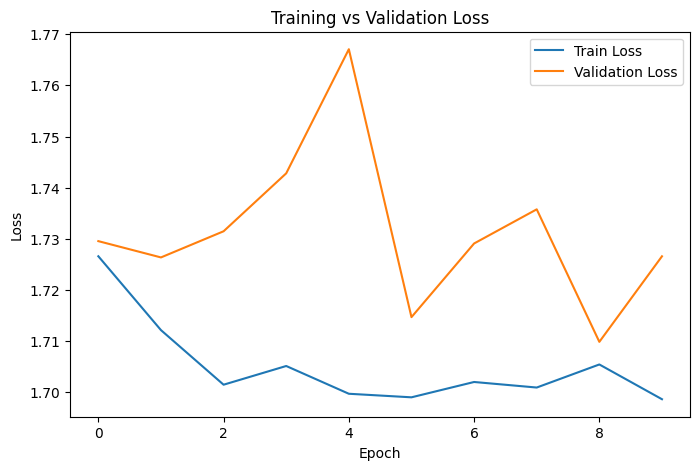

In [9]:
## 📉 5. Training Curves
# Visualize loss curves to assess model performance and detect overfitting.

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [10]:
## 🧪 6. Model Evaluation
# We’ll compute final test accuracy and visualize a few predictions.

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

Final Test Accuracy: 40.92%


In [ ]:
## 📘 Theory Notes — Model Evaluation & Overfitting

#---

### 📊 Understanding Model Performance

#After training, evaluating your model helps ensure it generalizes well beyond the data it learned from.  
#The two most common metrics are **loss** and **accuracy**:

#- **Training Loss** → measures how well the model fits the training data.  
#- **Validation/Test Loss** → measures generalization to unseen data.  
#- **Accuracy** → percentage of correctly classified images.

#✅ **Goal:**  
#You want low loss and high accuracy **on both training and validation sets**, which indicates balanced learning.

#---

### ⚖️ Bias vs. Variance Trade-Off

#Model performance is often limited by two key errors:
#- **High Bias (Underfitting):** The model is too simple and can’t capture underlying patterns.  
#  - Symptoms: High loss, low accuracy on both train and validation data.  
#- **High Variance (Overfitting):** The model fits training data too closely and fails to generalize.  
#  - Symptoms: Low training loss but high validation loss.  

#**Best practice:**  
#- Use data augmentation, dropout, and early stopping to control overfitting.  
#- Plot learning curves (loss vs. epoch) — divergence between curves signals overfitting.

#---

### 🧠 Evaluating CNN Predictions

#A good evaluation includes:
#- **Confusion matrix:** highlights which classes are being confused.  
#- **Per-class accuracy:** ensures model performance is balanced across labels.  
#- **Qualitative review:** visually inspect misclassified images to spot systematic issues.

#---

#📈 *By combining quantitative metrics with visual inspection, you can interpret how well your model learned and identify areas for improvement before deployment.*


In [11]:
## 💾 7. Save Model
#We’ll save the trained model to use later in our FastAPI inference pipeline.

os.makedirs("../models", exist_ok=True)
torch.save(model.state_dict(), "../models/best_model.pt")

In [12]:
# ✅ Verify That the File Exists

model_path = "../models/best_model.pt"
if os.path.exists(model_path):
    print(f"✅ Model file found at: {model_path}")
else:
    print("❌ Model file not found - check your save path.")

✅ Model file found at: ../models/best_model.pt


In [13]:
# ✅ Verify that model file can be load successfully
checkpoint_model = models.resnet18(weights=None)
num_ftrs = checkpoint_model.fc.in_features
checkpoint_model.fc = nn.Linear(num_ftrs, 10)  # 10 classes for CIFAR-10

# Load weights
checkpoint_model.load_state_dict(torch.load(model_path, map_location=device))
checkpoint_model.eval()
print("✅ Model weights loaded successfully and ready for inference.")

✅ Model weights loaded successfully and ready for inference.


In [ ]:
## 🧩 Key Takeaways

# - **Transfer Learning** drastically reduces training time and improves performance on small datasets.
# - **Freezing early layers** leverages pretrained visual features from ImageNet.
# - This trained model will be integratedinto the `/predict` endpoint in our FastAPI app next